In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from river.datasets import CreditCard
from IncrementalTorch.datasets import Covertype, Shuttle

warnings.filterwarnings('ignore')

## Arranging Tables Benchmark
Taken from https://github.com/himanshudce/DAADS

In [3]:
benchmark_csv = pd.read_csv('../results/old_seed/Benchmark.csv')
benchmark_csv = benchmark_csv[['dataset','model','PR-AUC','ROC-AUC','runtime']]
benchmark_csv.head()

,dataset,model,PR-AUC,ROC-AUC,runtime
0,covertype,AE,0.265724,0.955638,166.821647
1,covertype,DAE,0.501184,0.984210,290.957385
2,covertype,PW-AE,0.450871,0.982017,320.041095
3,creditcard,AE,0.234189,0.940027,186.723872
4,creditcard,DAE,0.247484,0.943084,267.283816


In [4]:
# model sorted list similar to paper
sorter = ['ILOF','HST','RRCF','xStream','Kit-Net','AE','DAE','PW-AE']
# Create the dictionary that defines the order for sorting
sorterIndex = dict(zip(sorter, range(len(sorter))))

In [5]:
df = benchmark_csv[benchmark_csv['dataset'] == 'covertype']
df['model_Rank'] = df['model'].map(sorterIndex)
df.sort_values(['model_Rank'],ascending = [True], inplace = True)
df.drop('model_Rank', 1, inplace = True)
df.reset_index(inplace=True,drop=True)
df

,dataset,model,PR-AUC,ROC-AUC,runtime
0,covertype,AE,0.265724,0.955638,166.821647
1,covertype,DAE,0.501184,0.984210,290.957385
2,covertype,PW-AE,0.450871,0.982017,320.041095


In [6]:
df = benchmark_csv[benchmark_csv['dataset'] == 'creditcard']
df['model_Rank'] = df['model'].map(sorterIndex)
df.sort_values(['model_Rank'],ascending = [True], inplace = True)
df.drop('model_Rank', 1, inplace = True)
df.reset_index(inplace=True,drop=True)
df

,dataset,model,PR-AUC,ROC-AUC,runtime
0,creditcard,AE,0.234189,0.940027,186.723872
1,creditcard,DAE,0.247484,0.943084,267.283816
2,creditcard,PW-AE,0.258441,0.944786,273.085871


## Cherry Picking Check

In [1]:
# Specify the model you want to filter by
target_models = ['AE', 'DAE', 'PW-AE']

# Specify the seed setting names
seed_settings = ['original', 'old_seeds', 'new_seeds']

# Select the list of metrics to plot
## All metrics
# metrics = ['PR-AUC', 'ROC-AUC', 'Max F1', 'Max F1 Precision', 'Max F1 Recall', 'runtime']
## Metrics used by the original paper
metrics = ['PR-AUC', 'ROC-AUC', 'runtime']

# Data columns
## All metrics
columns = ['PR-AUC', 'ROC-AUC', 'Max F1', 'Max F1 Precision', 'Max F1 Recall', 'runtime', 'status', 'model', 'subsample', 'preprocessor', 'postprocessor', 'seed', 'lr', 'latent_dim', 'dataset']
## Metrics used by the original paper
columns = ['PR-AUC', 'ROC-AUC', 'runtime', 'status', 'model', 'subsample', 'preprocessor', 'postprocessor', 'seed', 'lr', 'latent_dim', 'dataset']


In [15]:
# Loading the datasets
benchmark_csv_new_seeds = pd.read_csv('../results/new_seed/Benchmark_raw_cython.csv')[columns]
# benchmark_csv_new_seeds = pd.read_csv('../results/new_seed/Benchmark_raw.csv')[columns]
benchmark_csv_old_seeds = pd.read_csv('../results/old_seed/Benchmark_raw.csv')[columns]
benchmark_csv_original = pd.read_csv('../results/original/Benchmark_raw.csv')[columns]

# Add an 'origin' column depending on the dataset origin
benchmark_csv_original['origin'] = seed_settings[0]
benchmark_csv_old_seeds['origin'] = seed_settings[1]
benchmark_csv_new_seeds['origin'] = seed_settings[2]

# Concatenate the datasets with origin key
benchmark_csv_merged = pd.concat([benchmark_csv_original, benchmark_csv_new_seeds, benchmark_csv_old_seeds], keys=seed_settings)

# Reset the index
benchmark_csv_merged.reset_index(drop=True, inplace=True)

# print(benchmark_csv_merged)

In [16]:
def box_plot_seed(benchmark_results, target_models, metrics):
    for target_model in target_models:
        # Filter the data for the specific model
        model_data = benchmark_results[benchmark_results['model'] == target_model]

        # Get unique datasets for the target model
        unique_datasets = model_data['dataset'].unique()

        num_metrics = len(metrics)
        num_datasets = len(unique_datasets)

        # Create subplots for each metric and dataset
        _, axs = plt.subplots(num_datasets, num_metrics, figsize=(16, 8), dpi=100, constrained_layout=True)

        for i, metric in enumerate(metrics):
            for j, dataset in enumerate(unique_datasets):
                ax = axs[j, i]
                
                # Filter data for both 'Original' and 'New' origins with the same metric and dataset
                original_data = model_data[(model_data['dataset'] == dataset) & (model_data['origin'] == seed_settings[0])]
                old_seeds_data = model_data[(model_data['dataset'] == dataset) & (model_data['origin'] == seed_settings[1])]
                new_seeds_data = model_data[(model_data['dataset'] == dataset) & (model_data['origin'] == seed_settings[2])]

                # Combine data for 'Original' and 'New' origins in the same subplot
                ax.boxplot([original_data[metric], old_seeds_data[metric], new_seeds_data[metric]], labels=seed_settings)
                ax.set_ylabel(metric)
                ax.set_title(f'{metric} - {dataset}')

                # Rotate the x-tick labels
                ax.set_xticklabels(['original', 'old_seeds', 'new_seeds'], rotation=45)

        plt.suptitle(f'Distribution of Metrics for {target_model} by Dataset and Metric', fontsize=16)
        plt.tight_layout()

    plt.show()

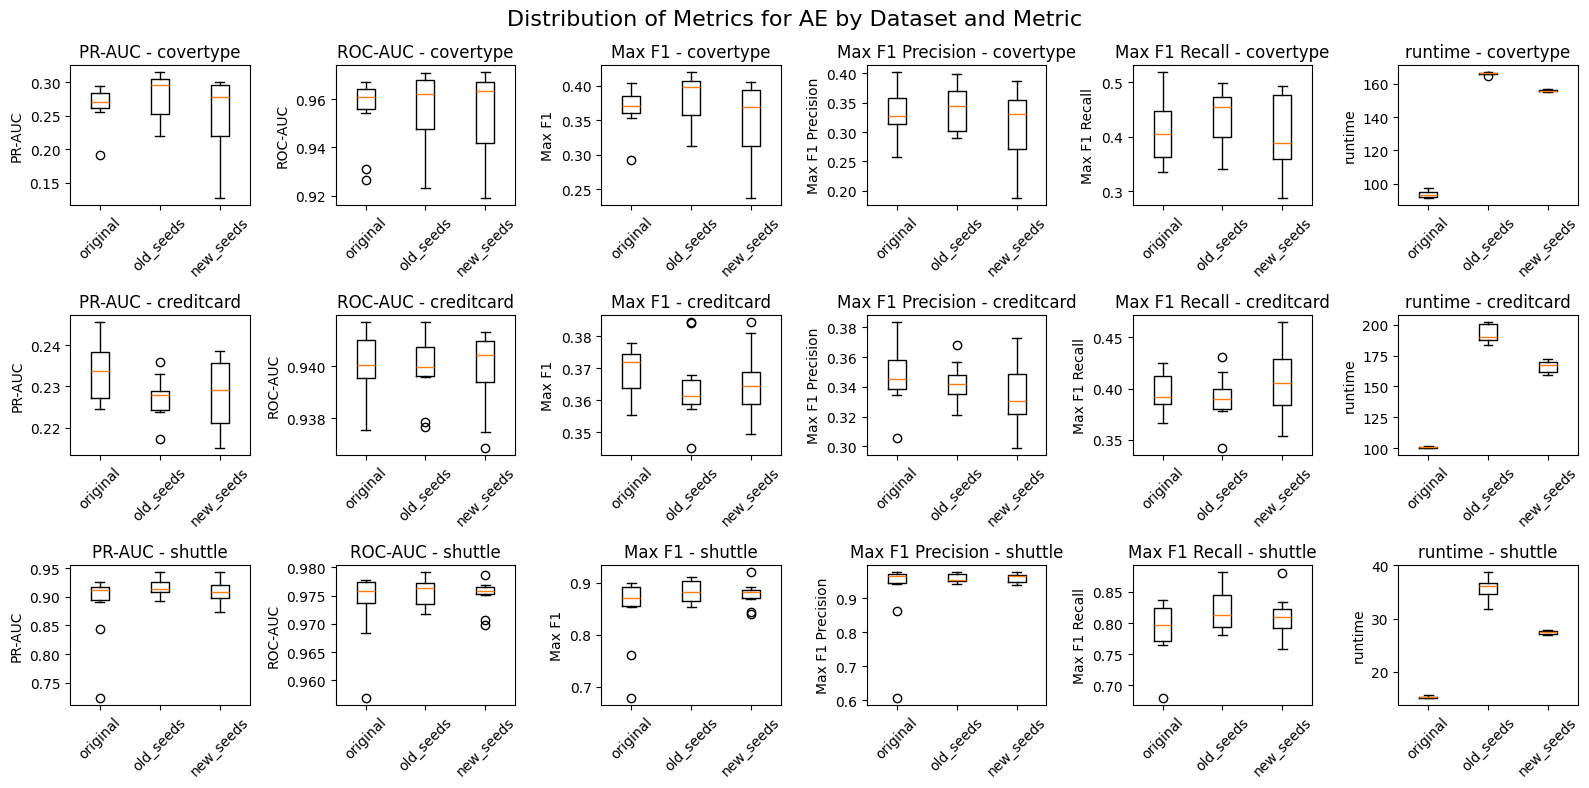

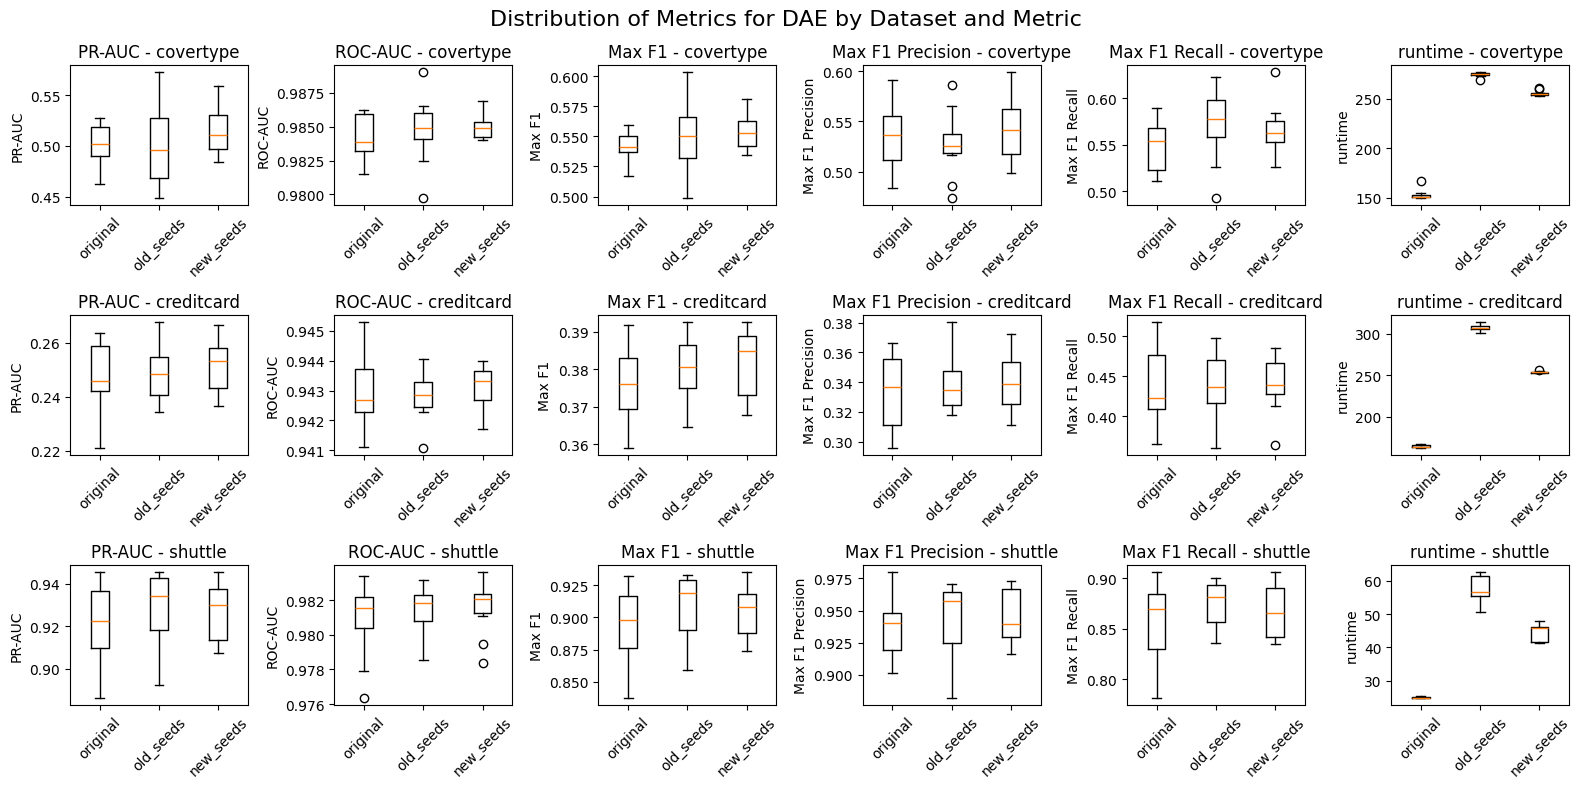

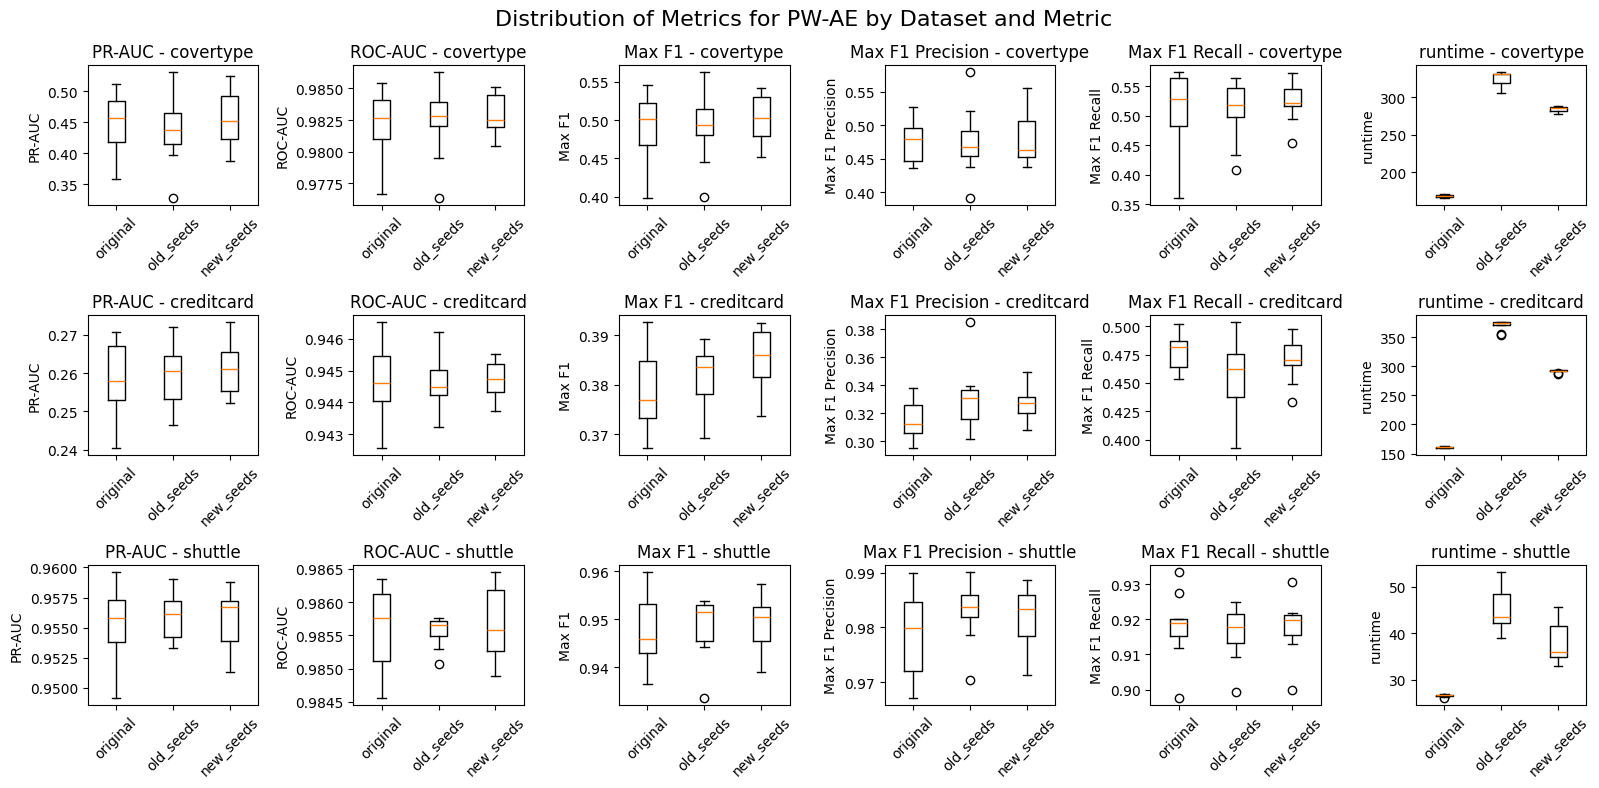

In [17]:
box_plot_seed(benchmark_results=benchmark_csv_merged, target_models=target_models, metrics=metrics)

In [18]:
# Filter the data to include only the target models
filtered_data = benchmark_csv_merged[benchmark_csv_merged['model'].isin(target_models)]

# Group the data by 'model', 'dataset' and 'prigin', and calculate mean and standard error for each metric
grouped = filtered_data.groupby(['model', 'dataset', 'origin'])
result = grouped[metrics].agg([np.mean, np.std])

# Rename the columns for clarity
result.columns = [f"{metric}_mean" for metric in metrics] + [f"{metric}_std" for metric in metrics]

# Create a custom column order
column_order = []
for metric in metrics:
    column_order.append(f"{metric}_mean")
    column_order.append(f"{metric}_std")

# Reorder the columns in the result DataFrame
result = result[column_order]
# Display the result
result

PR-AUC_mean  PR-AUC_std  ROC-AUC_mean  \
model dataset    origin                                             
AE    covertype  new_seeds     0.248624    0.305489      0.061843   
                 old_seeds     0.279338    0.338867      0.034021   
                 original      0.265724    0.336382      0.028899   
      creditcard new_seeds     0.228087    0.333760      0.008833   
                 old_seeds     0.227318    0.342399      0.005116   
                 original      0.234189    0.346709      0.007771   
      shuttle    new_seeds     0.908907    0.961237      0.020031   
                 old_seeds     0.915604    0.959113      0.016257   
                 original      0.886373    0.919793      0.062163   
DAE   covertype  new_seeds     0.515225    0.544227      0.023566   
                 old_seeds     0.499744    0.527580      0.039619   
                 original      0.500619    0.534143      0.022935   
      creditcard new_seeds     0.251945    0.339577      0.010416   
                 old_seeds     0.248962    0.339057      0.010917   
                 original      0.247251    0.333658      0.013322   
      shuttle    new_seeds     0.927194    0.945657      0.014553   
                 old_seeds     0.927544    0.941199      0.018829   
                 original      0.922183    0.936684      0.019238   
PW-AE covertype  new_seeds     0.458280    0.482482      0.047274   
                 old_seeds     0.437285    0.475045      0.055082   
                 original      0.450640    0.475974      0.050383   
      creditcard new_seeds     0.261417    0.326512      0.007079   
                 old_seeds     0.259414    0.330584      0.007856   
                 original      0.258198    0.314797      0.009895   
      shuttle    new_seeds     0.955661    0.982250      0.002462   
                 old_seeds     0.956070    0.983160      0.002131   
                 original      0.955122    0.978897      0.003553   

                            ROC-AUC_std  Max F1_mean  Max F1_std  \
model dataset    origin                                            
AE    covertype  new_seeds     0.067784     0.952971    0.406807   
                 old_seeds     0.038754     0.956201    0.438588   
                 original      0.043525     0.955638    0.411503   
      creditcard new_seeds     0.022740     0.939852    0.406911   
                 old_seeds     0.013578     0.939871    0.390244   
                 original      0.020387     0.940027    0.395528   
      shuttle    new_seeds     0.012769     0.975122    0.808146   
                 old_seeds     0.013760     0.975684    0.819225   
                 original      0.115722     0.973411    0.789376   
DAE   covertype  new_seeds     0.034543     0.985014    0.566436   
                 old_seeds     0.033172     0.984750    0.570914   
                 original      0.033584     0.984261    0.549472   
      creditcard new_seeds     0.019643     0.943122    0.439837   
                 old_seeds     0.020322     0.942860    0.437602   
                 original      0.026651     0.942994    0.436585   
      shuttle    new_seeds     0.021955     0.981588    0.867901   
                 old_seeds     0.031320     0.981335    0.873398   
                 original      0.023067     0.980911    0.857220   
PW-AE covertype  new_seeds     0.042904     0.983022    0.525555   
                 old_seeds     0.050386     0.982438    0.510011   
                 original      0.031907     0.982107    0.509756   
      creditcard new_seeds     0.011783     0.944705    0.470528   
                 old_seeds     0.023103     0.944587    0.456301   
                 original      0.013908     0.944672    0.477439   
      shuttle    new_seeds     0.005551     0.985676    0.918001   
                 old_seeds     0.005655     0.985557    0.916320   
                 original      0.007818     0.985576    0.918086   

                            Max F1 Precision_mean  Ma

https://stackoverflow.com/questions/50208918/python-pandas-find-statistical-difference-between-2-distributions


In [ ]:
from scipy import stats

merged = pd.merge(
    df.a.value_counts().to_frame(),
    df.b.value_counts().to_frame(),
    left_index=True,
    right_index=True)

stats.ks_2samp(merged.a, merged.b)